In [1]:
#%% Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import "local" packages
import hyspec_io, hyspec_ml, image_render, preprocess 

2024-02-21 11:13:58.507919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%% Paths
tmp_save_dir = Path('/media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint')
# im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_31-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_32-Crop Wavelengths.bip.hdr', # første eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_79-Crop Wavelengths.bip.hdr', # dyp sand midt i bildet
#             '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_24-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr', # godt eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_42-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_20-Crop Wavelengths.bip.hdr', # godt eksempel
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_25-Crop Wavelengths.bip.hdr',
#             '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr'] # godt eksempel

im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_20-Crop Wavelengths.bip.hdr', 
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_25-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr'] 
im_paths = [Path(p) for p in im_paths]
sgc_train_im_paths = im_paths 


In [3]:
def train_image_pca(image_paths,n_components=8,random_sample_frac=0.05, normalize=True, verbose=False):
    """ Train PCA model based on randomly sampled spectra from multiple hyperspectral images 
    
    # Input arguments:
    image_paths:
        List of paths to images to include in the dataset for 
        fitting the PCA model.
    
    # Keyword arguments:
    n_components:
        Number of PCA components to include. If None, all components are kept.
    random_sample_frac:
        Indicates the fraction of pixels in the image that will be included
        in the training data for the PCA model. Example:
        random_sample_frac=0.05 indicates that 5% of pixels are extracted.
    normalize:
        Boolean indicating if data should be normalized before fitting the 
        PCA model. If True, spectra are normalized per-wavelength by
        subtracting the mean and dividing by the standard deviation ("z-score").
    verbose:
        Boolean indicating if status updates will be printed during processing.

    # Returns:
    W_pca:
        PCA "components", principal axes representing directions of maximal variance
        in feature space. Shape (n_components, n_features)
    X_mean:
        Per-wavelength mean of data. Shape(n_features,)
    X_scale:
        Per-wavelength scaling of data. Shape (n_features,).
        Corresponds to per-wavelength standard deviation. 
        Only returned if normalize = True .
    
    # Notes:
    The PCA model is fitted using sklearn.decomposition.PCA. The data is always "centered", 
    i.e. the mean value is subtracted. When applying the PCA model to new data, the same
    centering operation should be done, using X_mean (not the mean value of the new data).
    If normalize = True, new data should also be scaled by dividing per-wavelength
    by X_scale.
    """
    # Status update
    if verbose: print(f'Collecting {random_sample_frac*100} % of pixels from {len(image_paths)} images for PCA model')

    # Collect data
    X = []
    for i,image_path in enumerate(image_paths):
        if verbose: print(f'Opening image {i+1} of {len(image_paths)}')
        (im,_,_,_) = hyspec_io.load_envi_image(image_path)
        X.append(hyspec_ml.random_sample_image(im,frac=random_sample_frac))
    X = np.concatenate(X)
    if verbose: print(f'Collected data matrix has shape {X.shape}')

    # Normalize data (optional)
    if normalize:
        if verbose: print('Normalizing data...')
        scaler = StandardScaler(with_mean=False)
        X = scaler.fit_transform(X)
        X_scale = scaler.scale_
    
    # Fit PCA model
    if verbose: print('Fitting PCA model...')
    pca = PCA(n_components=n_components)
    pca.fit(X)
    if verbose: print('Done.')

    # Return
    if normalize:
        return (pca.components_, pca.mean_,X_scale)
    else:
        return (pca.components_, pca.mean_)
    


In [4]:
# W_pca, X_mean, X_scale = train_image_pca(image_paths=sgc_train_im_paths,verbose=True)
W_pca, X_mean = train_image_pca(image_paths=sgc_train_im_paths,verbose=True,normalize=False)

Opening image 1 of 3
Opening image 2 of 3
Opening image 3 of 3
Collected data matrix has shape (270000, 255)
Fitting PCA model...
Done.


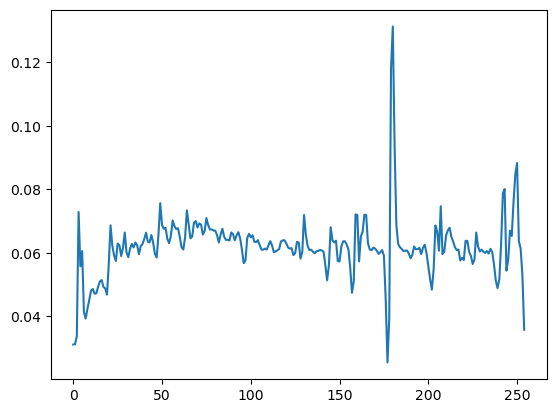

In [5]:
plt.plot(W_pca[0])

In [7]:
(image,wl,rgb_ind,_) = hyspec_io.load_envi_image(im_paths[-2])

In [15]:
def remove_sun_glint_pca(image,W_pca,X_mean):
    """ Remove sun glint by subtracting data corresponding to first principal component 
    
    # Input parameters:
    image:
        Hyperspectral image, shape (n_rows, n_columns, n_wavelengths)
    W_pca:
        PCA components (princical axes of highest variance) 
        Shape (n_components, n_wavelenghts)
        Note that only the first principal component is used.
    X_mean:
        Per-wavelength mean value of data used to fit PCA model.
        Shape (n_wavelengths,)
    """
    image_vectorizer = hyspec_ml.ImageVectorizer(nRows=image.shape[0],nCols=image.shape[1])
    nonzero_mask = ~np.all(image==0,axis=2,keepdims=True)

    # Subtract mean and multiply to get "first component image"
    image_2d = image_vectorizer.image3d_to_matrix(image)
    image_2d_centered = image_2d - np.reshape(X_mean,(1,-1))
    print(f'{image_2d_centered.shape=}')
    image_2d_pc1 = image_2d_centered @ W_pca[0:1,:].T # NOTE: Transposing PCA weights here. May not be consistently across code.
    return image_2d_pc1

    # PCA transform through matrix multiplication (projection to rotated coordinate system)
    # im_vec_pca = im_vec_norm @ W_pca
    
    # Reshape into image, and ensure that zero-value input pixels are also zero in output
    # im_pca = np.reshape(im_vec_pca,image.shape[0:2]+(im_vec_pca.shape[-1],))*nonzero_mask



In [16]:
image_pc1 = remove_sun_glint_pca(image,W_pca,X_mean)

image_2d_centered.shape=(1800000, 255)


In [17]:
print(image_pc1.shape)

(1800000, 1)


In [ ]:
# Vectorize image
im_vectorizer = hyspec_ml.ImageVectorizer(nRows=im.shape[0],nCols=im.shape[1])
im_2d = im_vectorizer.image3d_to_matrix(im)
print(f'Shape of original image: {im.shape}')
print(f'Shape of vectorized image: {im_2d.shape}')

Shape of original image: (2000, 900, 255)
Shape of vectorized image: (1800000, 255)


In [ ]:
# Z-score transform
z_scaler = StandardScaler()
im_2d_norm = z_scaler.fit_transform(im_2d)

In [ ]:
# PCA transform 
pca = PCA(n_components=6)
im_2d_pca = pca.fit_transform(im_2d_norm)

In [ ]:
im_pca = im_vectorizer.matrix_to_image3d(im_2d_pca)
print(f'Shape of PCA image: {im_pca.shape}')

Shape of PCA image: (2000, 900, 6)


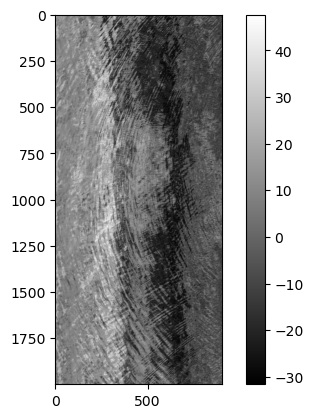

In [ ]:
plt.imshow(im_pca[:,:,0],cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
X_mean = pca.mean_
W_pca = pca.components_
print(W_pca.shape)

(6, 255)


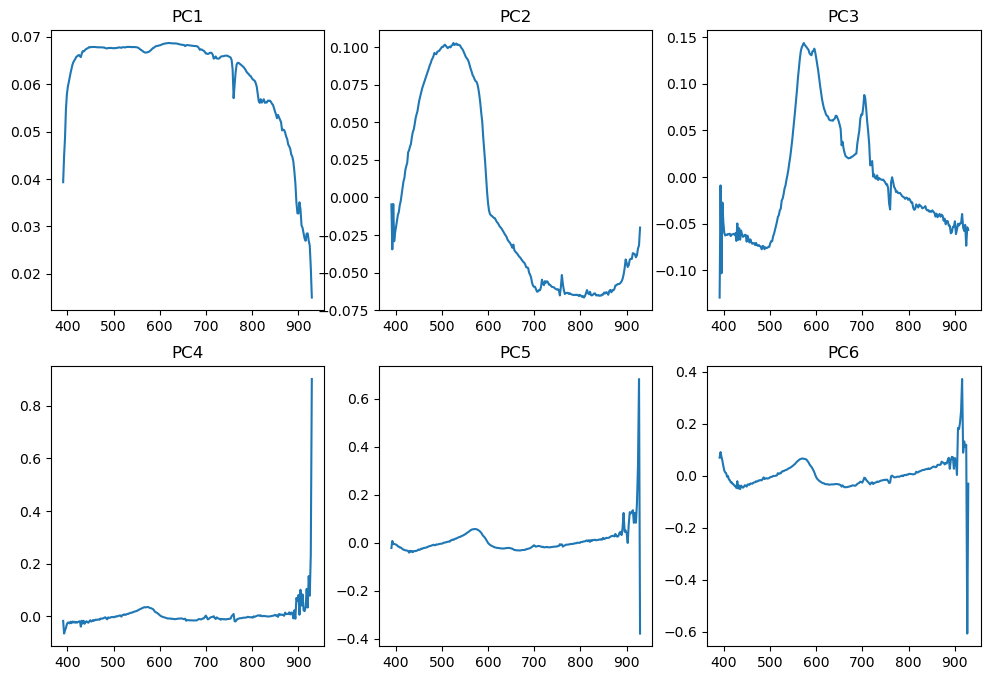

In [ ]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(12,8))
for i,ax in enumerate(axes.reshape(-1)):
    ax.plot(wl,W_pca[i])
    ax.set_title(f'PC{i+1}')
plt.show()

# Note on principal component shape
The principal components shown here (based on normalized spectra) are different from the components calculated based on non-normalized spectra. 
- In both cases, PC1 looks fairly "flat". With normalization, it's fairly smooth, and also tapers off towards the high and low end. Without normalization, PC1 looks much more "noisy", and does not taper off as much.
- PC2 looks very similar to the typical "deep sand" spectrum.
- PC3 has similarities to algae spectra, with a peak around 600 nm, a small peak/shoulder at 640 nm, a dip at 670 nm and part of the red edge around 700 nm. 

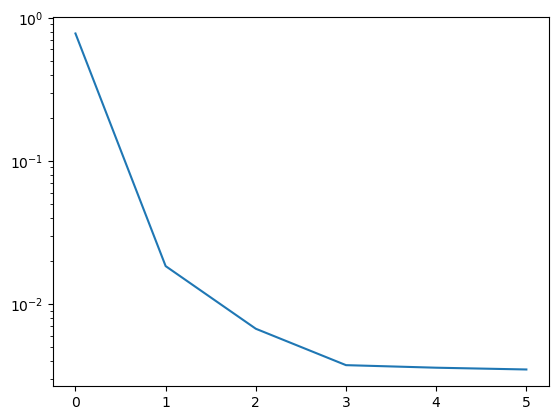

In [ ]:
# Show explained varance 
plt.semilogy(pca.explained_variance_ratio_)
plt.show()

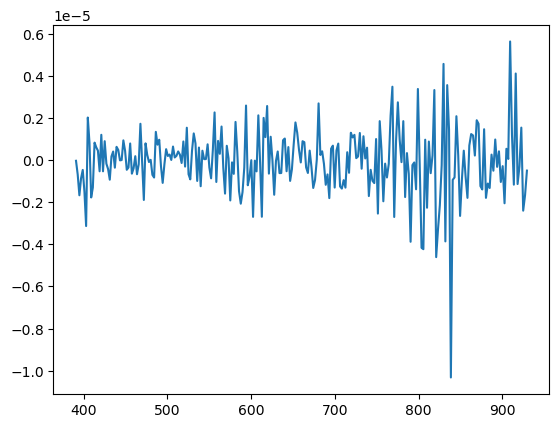

In [ ]:
plt.plot(wl,X_mean)

In [ ]:
pc1 = W_pca[0]
pc1 = pc1.reshape((1,-1))
print(pc1.shape)

(1, 255)


In [ ]:
# Construct glint image based on PC1
im_2d_pc1 = im_2d_pca[:,0:1]
im_2d_glint = im_2d_pc1*pc1 
im_glint = im_vectorizer.matrix_to_image3d(im_2d_glint)
print(im_2d_glint.shape)

(1800000, 255)


In [ ]:
# Subtract glint from original (normalized) image, and reverse normalization  
im_noglint = im_vectorizer.matrix_to_image3d(z_scaler.inverse_transform(im_2d_norm - im_2d_glint))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


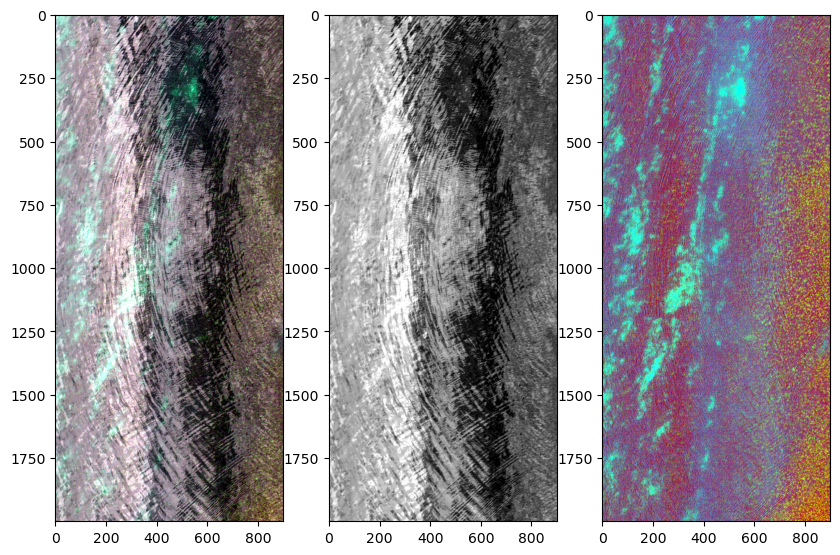

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_glint[:,:,rgb_ind]))
ax[2].imshow(image_render.percentile_stretch(im_noglint[:,:,rgb_ind]))
plt.show()

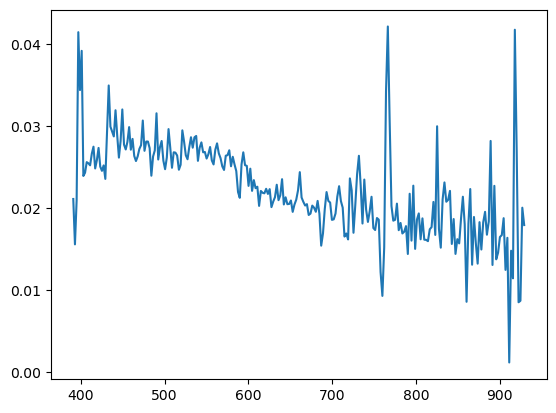

In [ ]:
plt.plot(wl,im_noglint[1000,600,:])

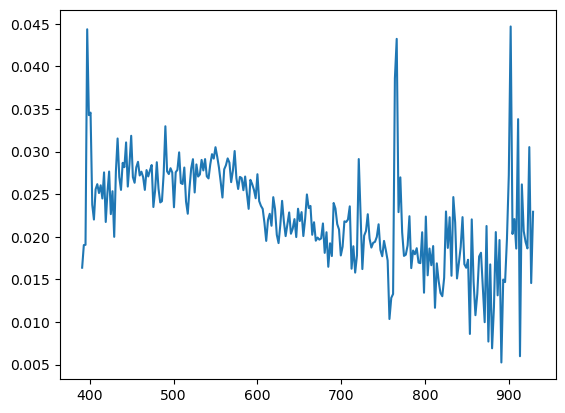

In [ ]:
plt.plot(wl,im_noglint[850,150,:])

In [ ]:
im_path

PosixPath('/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr')

In [ ]:
# Update metadata
metadata_mod = metadata.copy()
metadata_mod['history'] += ' -> SunGlintCorrectPCA'
print(metadata_mod['history'])

input cube -> ReflectivityConversion<SpecGroup>[<SpecFloat label:'Saturation Value' value:4095.0>, <SpecBool label:'Set saturated pixels to zero?' value:True>, <SpecSpectrum label:'Correlation Coefficients' value:None>, <SpecBool label:'Use Correlation Coefficients' value:False>, <SpecChoice label:'Scale 100% Reflectivity To:' value:1.0 (floats)>, <SpecFilename label:'Downwelling Offset' value:>, <SpecSpectrum label:'Downwelling Dark Spectrum' value:None>, <SpecBool label:'Auto Remove Downwelling Dark Noise?' value:True>, <SpecFilename label:'Downwelling Calibration' value:F:\Smola_Maholmen\Hyperspectral\20230621\_Calibration\FLMS16638_Radiometric_Jan2021.dcp>, <SpecSpectrum label:'Downwelling Spectrum' value:None>, <SpecBool label:'Use Downwelling Spectrum in Source Folder' value:True>, <SpecChoice label:'Downwelling Type' value:Resonon Calibrated>, <SpecCube label:'Dark Noise Cube' value:None>, <SpecBool label:'Auto Remove Dark Noise?' value:True>, <SpecFilename label:'Imager Calibra

In [ ]:
# Create new file name
file_base, file_ext = im_path.name.split('.',maxsplit=1)
save_file_path = tmp_save_dir / (file_base + '_PCASGC.' + file_ext) 
print(f'Saving image to file {save_file_path}')

Saving image to file /media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint/Maholmen_03_Pika_L_32-Crop Wavelengths_PCASGC.bip.hdr


In [ ]:
# Save image
hyspec_io.save_envi_image(str(save_file_path),im_noglint,metadata_mod)